In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

class MarketingDataset(Dataset):
    def __init__(self, file_path, tokenizer):
        self.tokenizer = tokenizer
        with open(file_path, 'r', encoding='utf-8') as f:
            self.lines = [line.strip() for line in f]
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        return torch.tensor(self.tokenizer.encode(self.lines[idx], add_special_tokens=True))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model.to(device)

train_dataset = MarketingDataset('text.txt', tokenizer)
valid_dataset = MarketingDataset('valid.txt', tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

optimizer = Adam(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

best_valid_loss = float('inf')

for epoch in range(3):
    train_loss = 0.0
    model.train()

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch, labels=batch)
        loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    
    train_loss /= len(train_dataset)
    valid_loss = 0.0
    model.eval()

    with torch.no_grad():
        for batch in valid_loader:
            batch = batch.to(device)
            output = model(batch, labels=batch)
            loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
            valid_loss += loss.item() * batch.size(0)
        valid_loss /= len(valid_dataset)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pt')


C:\Users\91932\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: stack expects each tensor to be equal size, but got [106] at entry 0 and [103] at entry 1

In [1]:
import re

def extract_keywords(review):
    # Define a list of common stop words to exclude from keywords
    stop_words = ['the', 'and', 'is', 'in', 'it', 'this', 'that']
    
    # Split the review into individual words
    words = re.findall(r'\w+', review.lower())
    
    # Filter out stop words and return the remaining keywords
    keywords = [word for word in words if word not in stop_words]
    return keywords

def find_best_match(review_keywords, response):
    # Initialize variables to store the best match and its score
    best_match = None
    best_score = 0
    
    # Extract keywords from the response
    response_keywords = extract_keywords(response)
    
    # Iterate over each keyword in the review
    for keyword in review_keywords:
        # Calculate the score for the keyword based on its presence in the response
        score = sum(keyword in word for word in response_keywords)
        
        # Check if the current score is higher than the previous best score
        if score > best_score:
            best_match = keyword
            best_score = score
    
    return best_match

# Example usage
review = "The food was delicious, but the service was slow."
response = "We apologize for the slow service. Our chef takes great pride in preparing delicious food."

review_keywords = extract_keywords(review)
best_match = find_best_match(review_keywords, response)

print("Review keywords:", review_keywords)
print("Best match in response:", best_match)


Review keywords: ['food', 'was', 'delicious', 'but', 'service', 'was', 'slow']
Best match in response: food


In [6]:
pip install sentence-transformers


  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Using cached torchvision-0.15.2-cp39-cp39-win_amd64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np

def calculate_similarity(review, responses):
    # Load pre-trained BERT model
    model = SentenceTransformer('bert-base-uncased')

    # Encode the review and responses into fixed-length embeddings
    review_embedding = model.encode([review])[0]
    response_embeddings = model.encode(responses)

    # Calculate cosine similarity between the review and each response
    similarity_scores = np.dot(response_embeddings, review_embedding) / (np.linalg.norm(response_embeddings, axis=1) * np.linalg.norm(review_embedding))

    # Find the index of the response with the highest similarity score
    best_match_index = np.argmax(similarity_scores)

    return responses[best_match_index]

# Example usage
review = "The food was delicious, but the service was slow."
responses = [
    "We apologize for the slow service. Our chef takes great pride in preparing delicious food.",
    "Thank you for your feedback. We will address the issue with our service staff.",
    "We are glad you enjoyed the food. We'll work on improving the service speed.",
]

best_response = calculate_similarity(review, responses)

print("Review:", review)
print("Best Response:", best_response)


C:\Users\91932\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No sentence-transformers model found with name C:\Users\91932/.cache\torch\sentence_transformers\bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\91932/.cache\torch\sentence_transformers\bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the 

Review: The food was delicious, but the service was slow.
Best Response: We apologize for the slow service. Our chef takes great pride in preparing delicious food.


In [2]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.utils.rnn import pad_sequence

class MarketingDataset(Dataset):
    def __init__(self, file_path, tokenizer):
        self.tokenizer = tokenizer
        with open(file_path, 'r', encoding='utf-8') as f:
            self.lines = [line.strip() for line in f]
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        return self.tokenizer.encode(self.lines[idx], add_special_tokens=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model.to(device)

train_dataset = MarketingDataset('text.txt', tokenizer)
valid_dataset = MarketingDataset('valid.txt', tokenizer)

def collate_fn(batch):
    input_ids = [torch.tensor(item) for item in batch]
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    return padded_input_ids

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

optimizer = Adam(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

best_valid_loss = float('inf')
num_epochs = 10  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch, labels=batch)
        loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    
    train_loss /= len(train_dataset)
    valid_loss = 0.0
    model.eval()

    with torch.no_grad():
        for batch in valid_loader:
            batch = batch.to(device)
            output = model(batch, labels=batch)
            loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
            valid_loss += loss.item() * batch.size(0)
        valid_loss /= len(valid_dataset)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pt')


TypeError: pad_sequence(): argument 'padding_value' (position 3) must be float, not NoneType

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.utils.rnn import pad_sequence

class MarketingDataset(Dataset):
    def __init__(self, file_path, tokenizer):
        self.tokenizer = tokenizer
        with open(file_path, 'r', encoding='utf-8') as f:
            self.lines = [line.strip() for line in f]
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        return self.tokenizer.encode(self.lines[idx], add_special_tokens=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model.to(device)

train_dataset = MarketingDataset('text.txt', tokenizer)
valid_dataset = MarketingDataset('valid.txt', tokenizer)

def collate_fn(batch):
    input_ids = [torch.tensor(item) for item in batch]
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    return padded_input_ids

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

optimizer = Adam(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

best_valid_loss = float('inf')
num_epochs = 10  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch, labels=batch)
        loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    
    train_loss /= len(train_dataset)
    valid_loss = 0.0
    model.eval()

    with torch.no_grad():
        for batch in valid_loader:
            batch = batch.to(device)
            output = model(batch, labels=batch)
            loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
            valid_loss += loss.item() * batch.size(0)
        valid_loss /= len(valid_dataset)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pt')


TypeError: pad_sequence(): argument 'padding_value' (position 3) must be float, not NoneType

In [4]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

class MarketingDataset(Dataset):
    def __init__(self, file_path, tokenizer):
        self.tokenizer = tokenizer
        with open(file_path, 'r', encoding='utf-8') as f:
            self.lines = [line.strip() for line in f]
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        return self.tokenizer.encode(self.lines[idx], add_special_tokens=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model.to(device)

train_dataset = MarketingDataset('text.txt', tokenizer)
valid_dataset = MarketingDataset('valid.txt', tokenizer)

def collate_fn(batch):
    input_ids = [torch.tensor(item) for item in batch]
    max_len = max(len(ids) for ids in input_ids)
    padded_input_ids = torch.stack([torch.cat((ids, torch.zeros(max_len - len(ids), dtype=torch.long))) for ids in input_ids])
    return padded_input_ids

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

optimizer = Adam(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

best_valid_loss = float('inf')
num_epochs = 10  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch, labels=batch)
        loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    
    train_loss /= len(train_dataset)
    valid_loss = 0.0
    model.eval()

    with torch.no_grad():
        for batch in valid_loader:
            batch = batch.to(device)
            output = model(batch, labels=batch)
            loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
            valid_loss += loss.item() * batch.size(0)
        valid_loss /= len(valid_dataset)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pt')


In [5]:
print(f"Epoch {epoch+1}/{num_epochs}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Valid Loss: {valid_loss:.4f}")

Epoch 10/10
Train Loss: 0.0156
Valid Loss: 0.0000


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

class MarketingDataset(Dataset):
    def __init__(self, file_path, tokenizer):
        self.tokenizer = tokenizer
        with open(file_path, 'r', encoding='utf-8') as f:
            self.lines = [line.strip() for line in f]
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        return self.tokenizer.encode(self.lines[idx], add_special_tokens=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model.to(device)

train_dataset = MarketingDataset('text.txt', tokenizer)
valid_dataset = MarketingDataset('valid.txt', tokenizer)

def collate_fn(batch):
    input_ids = [torch.tensor(item) for item in batch]
    max_len = max(len(ids) for ids in input_ids)
    padded_input_ids = torch.stack([torch.cat((ids, torch.zeros(max_len - len(ids), dtype=torch.long))) for ids in input_ids])
    return padded_input_ids

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

optimizer = Adam(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

best_valid_loss = float('inf')
num_epochs = 10  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch, labels=batch)
        loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    
    train_loss /= len(train_dataset)
    valid_loss = 0.0
    model.eval()

    with torch.no_grad():
        for batch in valid_loader:
            batch = batch.to(device)
            output = model(batch, labels=batch)
            loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
            valid_loss += loss.item() * batch.size(0)
        valid_loss /= len(valid_dataset)
        
    perplexity = torch.exp(torch.tensor(valid_loss))
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model2.pt')
        
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}")
    print(f"Perplexity: {perplexity:.2f}")
    print("--------------------")

print("Training completed!")


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Load the pre-trained GPT-3 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Load the pre-trained GPT-3 model
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Load the text dataset
dataset = TextDataset(
    tokenizer=tokenizer,
    file_path='inputs.txt',
    block_size=512
)

# Create a data collator for language modeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False, num_samples=10)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=32,
    learning_rate=5e-5,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Define the trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator
)

# Fine-tune the language model
trainer.train()

# Save the fine-tuned model
trainer.save_model('./best_model3.pt')


In [10]:
pip install matplotlib


                                              0.0/7.6 MB ? eta -:--:--
                                              0.0/7.6 MB ? eta -:--:--
                                              0.0/7.6 MB ? eta -:--:--
                                              0.1/7.6 MB 751.6 kB/s eta 0:00:11
                                              0.1/7.6 MB 751.6 kB/s eta 0:00:11
     -                                        0.2/7.6 MB 787.7 kB/s eta 0:00:10
     -                                        0.2/7.6 MB 919.0 kB/s eta 0:00:09
     -                                        0.3/7.6 MB 886.2 kB/s eta 0:00:09
     -                                        0.4/7.6 MB 1.0 MB/s eta 0:00:08
     --                                       0.4/7.6 MB 933.2 kB/s eta 0:00:08
     --                                       0.5/7.6 MB 1.1 MB/s eta 0:00:07
     --                                       0.5/7.6 MB 1.1 MB/s eta 0:00:07
     ---                                      0.6/7.6 MB 1.1 MB/s eta 0:

Matplotlib is building the font cache; this may take a moment.


Epoch 1/10
Train Loss: 1.5466
Valid Loss: 0.0139
Perplexity: 1.01
--------------------
Epoch 2/10
Train Loss: 0.0495
Valid Loss: 0.0055
Perplexity: 1.01
--------------------
Epoch 3/10
Train Loss: 0.0297
Valid Loss: 0.0018
Perplexity: 1.00
--------------------
Epoch 4/10
Train Loss: 0.0252
Valid Loss: 0.0005
Perplexity: 1.00
--------------------
Epoch 5/10
Train Loss: 0.0196
Valid Loss: 0.0003
Perplexity: 1.00
--------------------
Epoch 6/10
Train Loss: 0.0225
Valid Loss: 0.0001
Perplexity: 1.00
--------------------
Epoch 7/10
Train Loss: 0.0198
Valid Loss: 0.0001
Perplexity: 1.00
--------------------
Epoch 8/10
Train Loss: 0.0176
Valid Loss: 0.0001
Perplexity: 1.00
--------------------
Epoch 9/10
Train Loss: 0.0197
Valid Loss: 0.0000
Perplexity: 1.00
--------------------
Epoch 10/10
Train Loss: 0.0197
Valid Loss: 0.0000
Perplexity: 1.00
--------------------
Training completed!


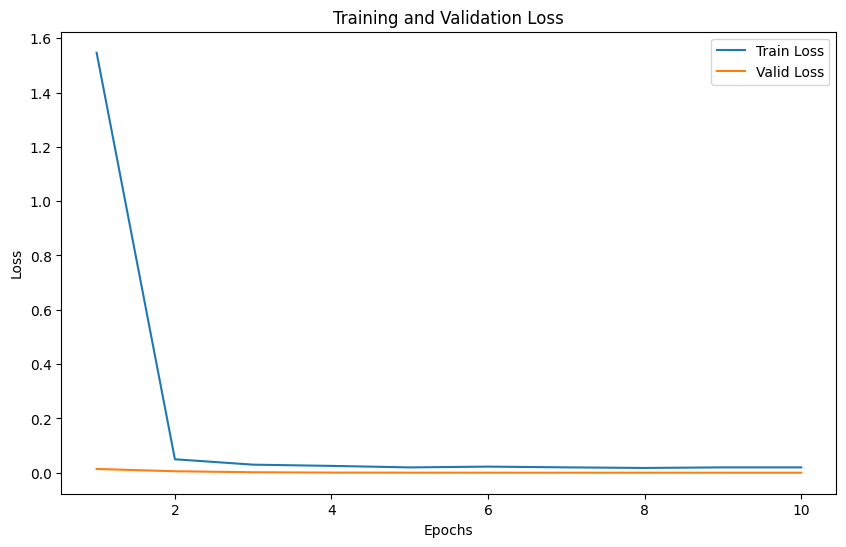

In [11]:
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

class MarketingDataset(Dataset):
    def __init__(self, file_path, tokenizer):
        self.tokenizer = tokenizer
        with open(file_path, 'r', encoding='utf-8') as f:
            self.lines = [line.strip() for line in f]
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        return self.tokenizer.encode(self.lines[idx], add_special_tokens=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model.to(device)

train_dataset = MarketingDataset('text.txt', tokenizer)
valid_dataset = MarketingDataset('valid.txt', tokenizer)

def collate_fn(batch):
    input_ids = [torch.tensor(item) for item in batch]
    max_len = max(len(ids) for ids in input_ids)
    padded_input_ids = torch.stack([torch.cat((ids, torch.zeros(max_len - len(ids), dtype=torch.long))) for ids in input_ids])
    return padded_input_ids

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

optimizer = Adam(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

best_valid_loss = float('inf')
num_epochs = 10  # Adjust the number of epochs as needed

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch, labels=batch)
        loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    
    train_loss /= len(train_dataset)
    valid_loss = 0.0
    model.eval()

    with torch.no_grad():
        for batch in valid_loader:
            batch = batch.to(device)
            output = model(batch, labels=batch)
            loss = criterion(output.logits.view(-1, output.logits.size(-1)), batch.view(-1))
            valid_loss += loss.item() * batch.size(0)
        valid_loss /= len(valid_dataset)
        
    perplexity = torch.exp(torch.tensor(valid_loss))
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model3.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}")
    print(f"Perplexity: {perplexity:.2f}")
    print("--------------------")

print("Training completed!")

# Plotting the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [15]:
model.save_pretrained('D:/College/SEM VI/IPD/mark/this', save_config=True)

C:\Users\91932\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\modeling_utils.py:1719: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(


In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2LMHeadModel.from_pretrained('D:/College/SEM VI/IPD/mark/this')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model.to(device)
model.eval()

def generate_text(prompt, max_length=100):
    input_ids = tokenizer.encode(prompt, add_special_tokens=True, return_tensors='pt').to(device)
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

# Example usage
prompt = "Write a subject line to review food was good"
generated_text = generate_text(prompt)
print("Generated Text:", generated_text)


C:\Users\91932\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text: Wrrite a subject line to review food was good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good
